In [1]:
!git config user.email "naazshafeer@gmail.com"
!git config user.name "Naaz Shafeer"

Modelling 2-Body Problem 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import scipy as sci
from scipy import integrate
from scipy.integrate import odeint
#astropy.units - 

In [4]:
#Define universal gravitation constant
G=6.67408e-11 #N-m2/kg2
#Define masses
m1=10e6 * 1.989e30 #mass of black hole A 
m2=10e8 * 1.989e30 #mass of black hole B
#Define initial position vectors
r1=[-0.5e14,0,0] #m
r2=[0.5e14,0,0] #m (convert these into actual meters instead of the reference used in last code block)
#Convert pos vectors to arrays
r1=np.array(r1,dtype="float64")
r2=np.array(r2,dtype="float64")
#Find Centre of Mass
r_com=(m1*r1+m2*r2)/(m1+m2)
#Define initial velocities
v1=[0,1e7, 0] #m/s
v2=[0,-1e7,0] #m/s
#Convert velocity vectors to arrays
v1=np.array(v1,dtype="float64")
v2=np.array(v2,dtype="float64")
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

#Now inputting Kepler's third law (to get the right orbital period, and fit ellipses, later)
r = np.linalg.norm(r2 - r1) #this is the Euclidean way to calculate distance, it is also used to find the potential energy
T = 2 * np.pi * np.sqrt(r**3 / (G * (m1 + m2)))

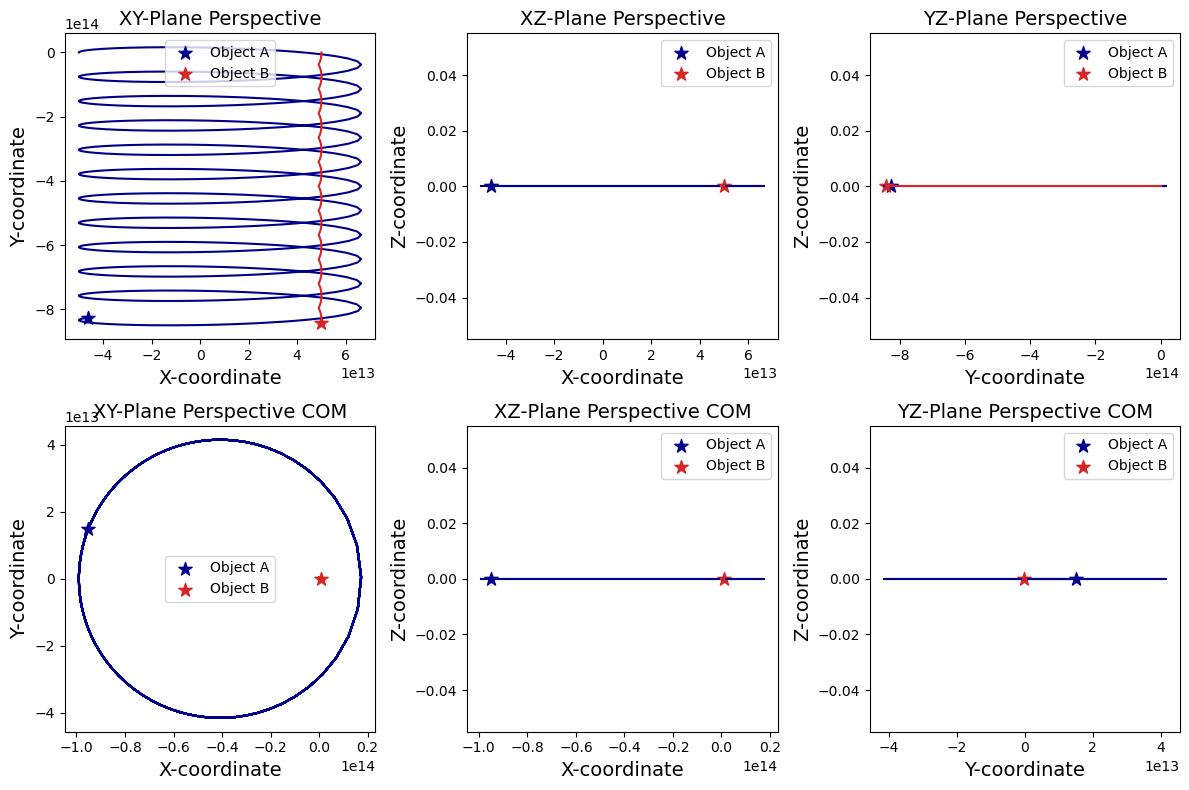

In [5]:
#A function defining the equations of motion 
def TwoBodyEquations(w,t,G,m1,m2):
    r1=w[:3]
    r2=w[3:6]
    v1=w[6:9]
    v2=w[9:12]
    r=np.linalg.norm(r2-r1) #Calculate magnitude or norm of vector
    dv1bydt=G*m2*(r2-r1)/r**3
    dv2bydt=G*m1*(r1-r2)/r**3
    dr1bydt=v1
    dr2bydt=v2
    r_derivs=np.concatenate((dr1bydt,dr2bydt))
    derivs=np.concatenate((r_derivs,dv1bydt,dv2bydt))
    return derivs
# check what w and t is in the code
#Package initial parameters
init_params=np.array([r1,r2,v1,v2]) #create array of initial params
init_params=init_params.flatten() #flatten array to make it 1D
time_span=np.linspace(0, 5 * T,1000) #8 orbital periods and 500 points #polar coordinates - [update] had to change
#this orbital period to 1 year in seconds (didnt know what to do so i asked chatgpt)


two_body_sol=sci.integrate.odeint(TwoBodyEquations,init_params,time_span,args=(G,m1,m2)) #make sure to understand what is within this variable

r1_sol = two_body_sol[:, :3]
r2_sol = two_body_sol[:, 3:6]

#Find location of COM
rcom_sol=(m1*r1_sol+m2*r2_sol)/(m1+m2)

r1com_sol=r1_sol-rcom_sol

r2com_sol=r2_sol-rcom_sol  #there is problem with viewpoint, i can only see things in teh COM viewpoint
#cannot trace the pathway of the orbit

#Create figure
fig, axs = plt.subplots(2, 3, figsize=(12, 8)) #looked at article to see how I can line up three differnt persepctives in a row

# region Code Snippet 1: Plot the orbits for XY plane (0,1) in indices
axs[0,0].plot(r1_sol[:,0],r1_sol[:,1],color="darkblue")
axs[0,0].plot(r2_sol[:,0],r2_sol[:,1],color="tab:red")
axs[0,0].scatter(r1_sol[-1,0],r1_sol[-1,1],color="darkblue",marker="*",s=100,label="Object A")
axs[0,0].scatter(r2_sol[-1,0],r2_sol[-1,1],color="tab:red",marker="*",s=100,label="Object B")
axs[0,0].set_xlabel("X-coordinate",fontsize=14)
axs[0,0].set_ylabel("Y-coordinate",fontsize=14)
axs[0,0].set_title("XY-Plane Perspective",fontsize=14)
axs[0,0].legend()
# endregion

# region Code Snippet 2: Plot the orbits for XZ plane (0,2) in indices
axs[0,1].plot(r1_sol[:,0],r1_sol[:,2],color="darkblue")
axs[0,1].plot(r2_sol[:,0],r2_sol[:,2],color="tab:red")
axs[0,1].scatter(r1_sol[-1,0],r1_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[0,1].scatter(r2_sol[-1,0],r2_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[0,1].set_xlabel("X-coordinate",fontsize=14)
axs[0,1].set_ylabel("Z-coordinate",fontsize=14)
axs[0,1].set_title("XZ-Plane Perspective",fontsize=14)
axs[0,1].legend()
# endregion

# region Code Snippet 3: Plot the orbits for YZ plane (1,2) in indices
axs[0,2].plot(r1_sol[:,1],r1_sol[:,2],color="darkblue")
axs[0,2].plot(r2_sol[:,1],r2_sol[:,2],color="tab:red")
axs[0,2].scatter(r1_sol[-1,1],r1_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[0,2].scatter(r2_sol[-1,1],r2_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[0,2].set_xlabel("Y-coordinate",fontsize=14)
axs[0,2].set_ylabel("Z-coordinate",fontsize=14)
axs[0,2].set_title("YZ-Plane Perspective",fontsize=14)
axs[0,2].legend()
# endregion

# region Code Snippet 4: Plot the orbits for XY plane (0,1) in indices but COM
axs[1,0].plot(r1com_sol[:,0],r1com_sol[:,1],color="darkblue")
axs[1,0].plot(r2com_sol[:,0],r2com_sol[:,1],color="tab:red")
axs[1,0].scatter(r1com_sol[-1,0],r1com_sol[-1,1],color="darkblue",marker="*",s=100,label="Object A")
axs[1,0].scatter(r2com_sol[-1,0],r2com_sol[-1,1],color="tab:red",marker="*",s=100,label="Object B")
axs[1,0].set_xlabel("X-coordinate",fontsize=14)
axs[1,0].set_ylabel("Y-coordinate",fontsize=14)
axs[1,0].set_title("XY-Plane Perspective COM",fontsize=14)
axs[1,0].legend()
# endregion

# region Code Snippet 5: Plot the orbits for XZ plane (0,2) in indices but COM
axs[1,1].plot(r1com_sol[:,0],r1com_sol[:,2],color="darkblue")
axs[1,1].plot(r2com_sol[:,0],r2com_sol[:,2],color="tab:red")
axs[1,1].scatter(r1com_sol[-1,0],r1com_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[1,1].scatter(r2com_sol[-1,0],r2com_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[1,1].set_xlabel("X-coordinate",fontsize=14)
axs[1,1].set_ylabel("Z-coordinate",fontsize=14)
axs[1,1].set_title("XZ-Plane Perspective COM",fontsize=14)
axs[1,1].legend()
# endregion

# region Code Snippet 6: Plot the orbits for YZ plane (1,2) in indices but COM
axs[1,2].plot(r1com_sol[:,1],r1com_sol[:,2],color="darkblue")
axs[1,2].plot(r2com_sol[:,1],r2com_sol[:,2],color="tab:red")
axs[1,2].scatter(r1com_sol[-1,1],r1com_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[1,2].scatter(r2com_sol[-1,1],r2com_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[1,2].set_xlabel("Y-coordinate",fontsize=14)
axs[1,2].set_ylabel("Z-coordinate",fontsize=14)
axs[1,2].set_title("YZ-Plane Perspective COM",fontsize=14)
axs[1,2].legend()
# endregion

plt.tight_layout() 
plt.show()


#make sure to check that the energy is conserved in all of these simulations

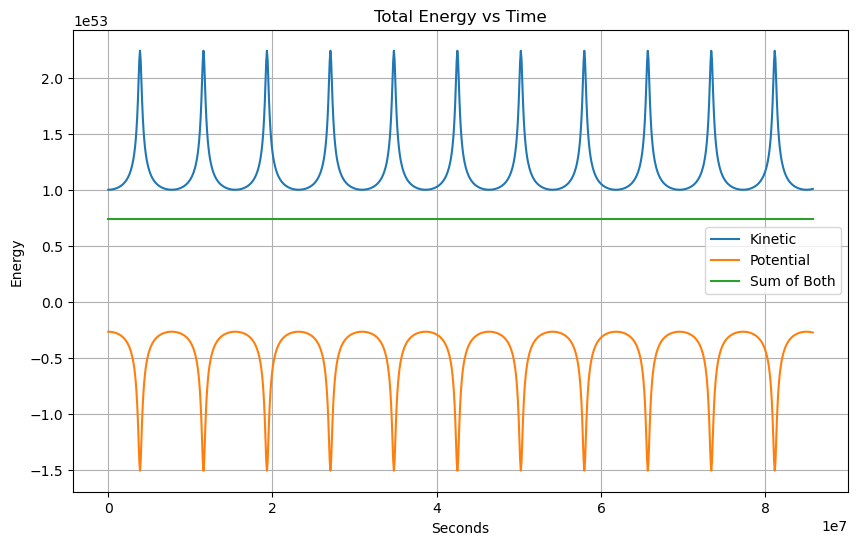

In [6]:
v1_sol = two_body_sol[:, 6:9]
v2_sol = two_body_sol[:, 9:12]

KE = 0.5 * m1 * np.sum(v1_sol**2, axis=1) + 0.5 * m2 * np.sum(v2_sol**2, axis=1)
V = -G * m1 * m2 / np.linalg.norm(r2_sol - r1_sol, axis=1) 
E = V + KE

dE_dt = np.gradient(E, time_span)


# region Code Snippet 6: Energy Graph Plot
plt.figure(figsize=(10, 6))
plt.plot(time_span, KE, label="Kinetic")
plt.plot(time_span, V, label = "Potential") 
plt.plot(time_span, E, label = "Sum of Both")
plt.xlabel("Seconds")
plt.ylabel("Energy")
plt.title("Total Energy vs Time")
plt.legend()
plt.grid()
plt.show()
# endregion

- the energy test (worked! some problems with de dt that i can figure out)
- all of keplers law (all three of them)
- periods to time ( do a function for that so we can switch back and forth) (used keplers third law for this)
after the periods to time we can check keplers third law
- review on the part where the switch from com to keplers thrid law 
- fit the ellpise equation to teh orbit and then extract the semi major axis from teh orbit and plug into this formula and plot like a 
- output two numbers (be careful with the units) 
- everything became unitless 
- calculate two different periods, sine they orbit the com separately
- fitting ellipses
- check units to see if the unitless stuff is distorting the data

Thursday:
- acceleration
- work on everything above!

In [8]:
def update(num, r1_sol, r2_sol, point1, point2):
    point1.set_data(r1_sol[num, 0], r1_sol[num, 1])
    point1.set_3d_properties(r1_sol[num, 2])
    point2.set_data(r2_sol[num, 0], r2_sol[num, 1])
    point2.set_3d_properties(r2_sol[num, 2])
    return point1, point2

# Create animation
anim = FuncAnimation(fig, update, frames=len(time_span), fargs=(r1_sol, r2_sol, point1, point2), interval=50, blit=True)

plt.show()



NameError: name 'FuncAnimation' is not defined

NameError: name 'R1_rel_COG' is not defined

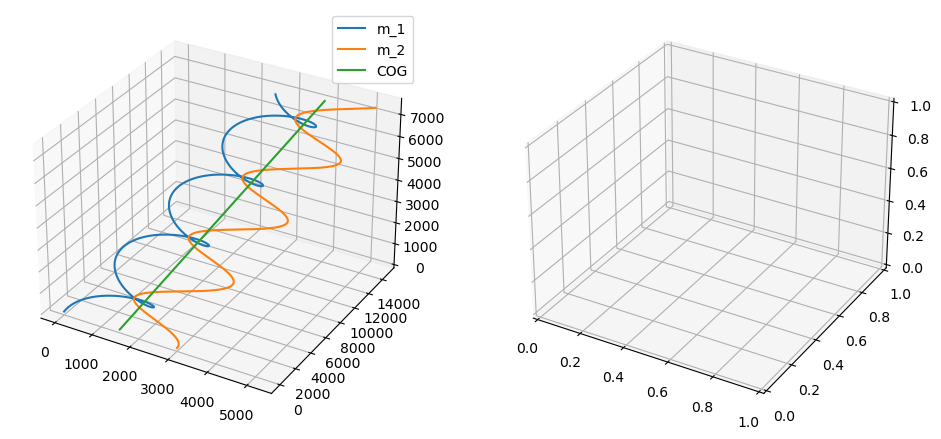

In [9]:
import numpy as np

G = 6.67430e-20  # km**3/(kg * s**2)
m_1 = m_2 = 1.0e26  # kg

R_1_0 = np.array((0, 0, 0))  # km
R_2_0 = np.array((3000, 0, 0))  # km
dotR_1_0 = np.array((10, 20, 30))  # km/s
dotR_2_0 = np.array((0, 40, 0))  # km/s

y_0 = np.hstack((R_1_0, R_2_0, dotR_1_0, dotR_2_0))

X_1 = y_0[0]
Y_1 = y_0[1]
Z_1 = y_0[2]
X_2 = y_0[3]
Y_2 = y_0[4]
Z_2 = y_0[5]

r = np.sqrt((X_2 - X_1) ** 2 + (Y_2 - Y_1) ** 2 + (Z_2 - Z_1) ** 2)

ddotX_1 = G * m_2 * (X_2 - X_1) / r**3
ddotY_1 = G * m_2 * (Y_2 - Y_1) / r**3
ddotZ_1 = G * m_2 * (Z_2 - Z_1) / r**3
ddotX_2 = -G * m_1 * (X_2 - X_1) / r**3
ddotY_2 = -G * m_1 * (Y_2 - Y_1) / r**3
ddotZ_2 = -G * m_1 * (Z_2 - Z_1) / r**3

R_1 = y_0[:3]
R_2 = y_0[3:6]

r = np.sqrt(np.sum(np.square(R_2 - R_1)))
ddot = G * (R_2 - R_1) / r**3
ddotR_1_0 = m_2 * ddot
ddotR_2_0 = -m_1 * ddot

Delta_t = 1  # s
dotR_1_1 = ddotR_1_0 * Delta_t + dotR_1_0
dotR_2_1 = ddotR_2_0 * Delta_t + dotR_2_0

R_1_1 = dotR_1_0 * Delta_t + R_1_0
R_2_1 = dotR_2_0 * Delta_t + R_2_0

import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


def absolute_motion(t, y):
    """Calculate the motion of a two-body system in an inertial reference frame.

    The state vector ``y`` should be in the order:

    1. Coordinates of $m_1$
    2. Coordinates of $m_2$
    3. Velocity components of $m_1$
    4. Velocity components of $m_2$
    """
    # Get the six coordinates for m_1 and m_2 from the state vector
    R_1 = y[:3]
    R_2 = y[3:6]

    # Fill the derivative vector with zeros
    ydot = np.zeros_like(y)

    # Set the first 6 elements of the derivative equal to the last
    # 6 elements of the state vector, which are the velocities
    ydot[:6] = y[6:]

    # Calculate the acceleration terms and fill them in to the rest
    # of the derivative array
    r = np.sqrt(np.sum(np.square(R_2 - R_1)))
    ddot = G * (R_2 - R_1) / r**3
    ddotR_1 = m_2 * ddot
    ddotR_2 = -m_1 * ddot

    ydot[6:9] = ddotR_1
    ydot[9:] = ddotR_2
    return ydot


t_0 = 0  # seconds
t_f = 480  # seconds
t_points = np.linspace(t_0, t_f, 1000)

sol = solve_ivp(absolute_motion, [t_0, t_f], y_0, t_eval=t_points)

y = sol.y.T
R_1 = y[:, :3]  # km
R_2 = y[:, 3:6]  # km
V_1 = y[:, 6:9]  # km/s
V_2 = y[:, 9:]  # km/s
barycenter = (m_1 * R_1 + m_2 * R_2) / (m_1 + m_2)  # km

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection="3d")
ax1.plot(R_1[:, 0], R_1[:, 1], R_1[:, 2], label="m_1")
ax1.plot(R_2[:, 0], R_2[:, 1], R_2[:, 2], label="m_2")
ax1.plot(barycenter[:, 0], barycenter[:, 1], barycenter[:, 2], label="COG")
ax1.legend()

ax2 = fig.add_subplot(132, projection="3d")
ax2.plot(R1_rel_COG[:, 0], R1_rel_COG[:, 1], R1_rel_COG[:, 2], label="m_1")
ax2.plot(R2_rel_COG[:, 0], R2_rel_COG[:, 1], R2_rel_COG[:, 2], label="m_2")
ax2.plot(0, 0, 0, "ro", label="COG")
ax2.legend()

ax3 = fig.add_subplot(133, projection="3d")
ax3.plot(R2_rel_R1[:, 0], R2_rel_R1[:, 1], R2_rel_R1[:, 2], label="m_2")
ax3.plot(COG_rel_R1[:, 0], COG_rel_R1[:, 1], COG_rel_R1[:, 2], label="COG")
ax3.plot(0, 0, 0, "ro", label="m_1")
ax3.legend()

plt.show()


